# Speech Digit Recognition 

This notebook presents an attention model for speech digit recognotion. 




In [1]:
useColab=True
if useColab:
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/requirements.txt
    !wget -q https://raw.githubusercontent.com/ralfgad/SpeechCmdRecognition/master/muestras_voz_def.zip      
    !pip install -r requirements.txt
    !unzip muestras_voz_def.zip

Archive:  muestras_voz_def.zip
   creating: muestras_voz/
   creating: muestras_voz/test/
   creating: muestras_voz/test/background/
  inflating: muestras_voz/test/background/0_2019-06-06-09h57m31s.wav.npy  
  inflating: muestras_voz/test/background/0_2019-06-06-09h57m36s.wav.npy  
  inflating: muestras_voz/test/background/0_2019-06-06-09h57m41s.wav.npy  
   creating: muestras_voz/test/cero/
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m36s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m42s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m48s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h50m54s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-03-10h51m06s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h38m20s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h38m27s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h38m33s.wav.npy  
  inflating: muestras_voz/test/cero/0_2019-06-06-08h3

In [2]:
%load_ext autoreload
%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

Using TensorFlow backend.


Añadimos google Drive

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=1, task = '10digit')

Done preparing Google Speech commands dataset version 1


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [5]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
214
11


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [6]:
sr=16000 #we know this one for google audios
iLen = 48000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
#handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

#use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

2

In [7]:
audios, classes = valGen.__getitem__(1)
classes

array([ 9,  6,  3,  5, 10,  9,  2,  6,  4,  8,  2,  5,  5,  2,  2, 10,  3,
       10,  4,  2,  1,  9,  2,  1,  5,  0,  4,  4,  3,  7,  8,  7, 10,  7,
        3,  8,  5,  8,  7,  9,  8,  9,  6,  6, 10,  2,  8,  8,  7,  4])

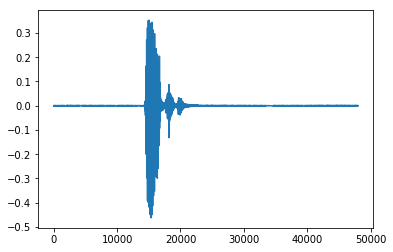

In [8]:
librosa.output.write_wav('file.wav', audios[5], sr, norm=False)
plt.plot(audios[5])

In [9]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

W0627 17:03:58.432029 140311488731008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 17:03:58.463315 140311488731008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 17:03:58.571144 140311488731008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 375, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 375, 1)        0         
Total params: 1,091,664
Trainable params: 0
Non-trainable params: 1,091,664
_________________________________________________________________


In [10]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

W0627 17:03:58.632816 140311488731008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0627 17:03:58.646166 140311488731008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



(50, 80, 375, 1)

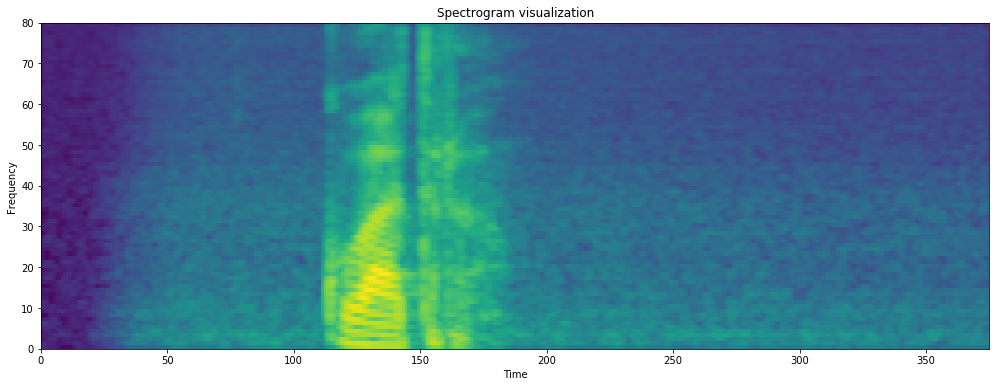

In [11]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[3,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

(array([5.0000e+00, 5.0000e+00, 5.0000e+00, 1.8000e+01, 1.5000e+01,
        3.4000e+01, 6.0000e+01, 1.0500e+02, 2.0300e+02, 3.7400e+02,
        6.8700e+02, 1.0260e+03, 1.6150e+03, 2.7290e+03, 5.0160e+03,
        7.9720e+03, 1.0706e+04, 1.1040e+04, 8.1120e+03, 5.5150e+03,
        4.4900e+03, 6.2540e+03, 1.3248e+04, 3.0638e+04, 5.5414e+04,
        7.6621e+04, 8.2161e+04, 7.4874e+04, 6.4467e+04, 5.8623e+04,
        5.4931e+04, 5.1039e+04, 4.8763e+04, 4.9770e+04, 5.2378e+04,
        5.4773e+04, 5.5196e+04, 5.5359e+04, 5.3040e+04, 5.0198e+04,
        4.5057e+04, 4.0166e+04, 3.5067e+04, 3.0550e+04, 2.6546e+04,
        2.3369e+04, 2.0600e+04, 1.7956e+04, 1.6182e+04, 1.4419e+04,
        1.2994e+04, 1.1942e+04, 1.1030e+04, 1.0538e+04, 9.9780e+03,
        9.5180e+03, 8.9920e+03, 8.8030e+03, 8.3660e+03, 7.7150e+03,
        7.1030e+03, 6.8350e+03, 6.2860e+03, 6.1570e+03, 5.7760e+03,
        5.4020e+03, 4.7670e+03, 4.6040e+03, 4.1260e+03, 3.7570e+03,
        3.5550e+03, 3.1790e+03, 3.0420e+03, 2.74

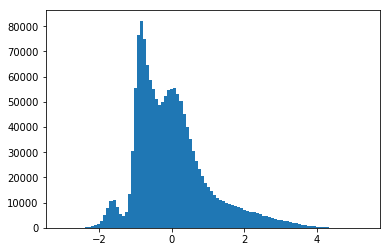

In [12]:
plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [0]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram

In [14]:
#self-attention LSTM
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = iLen)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

W0627 17:04:06.358298 140311488731008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0627 17:04:08.971739 140311488731008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48000)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 48000)     0           input_1[0][0]                    
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 375, 1)   1091664     reshape_1[0][0]                  
__________________________________________________________________________________________________
normalization2d_2 (Normalizatio (None, 80, 375, 1)   0           mel_stft[0][0]                   
__________________________________________________________________________________________________
permute_1 

In [0]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

# Entrenamiento

In [16]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results = model.fit_generator(trainGen, validation_data = valGen, epochs = 40, use_multiprocessing=True, workers=4,
                    callbacks=[earlystopper, checkpointer, lrate])

W0627 17:04:09.227895 140311488731008 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
Changing learning rate to 0.001
3/4 [=====================>........] - ETA: 0s - loss: 2.4242 - sparse_categorical_accuracy: 0.0667

4/4 [==============================] - 4s 1s/step - loss: 2.4270 - sparse_categorical_accuracy: 0.0650 - val_loss: 2.3968 - val_sparse_categorical_accuracy: 0.1000

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.10000, saving model to model-attRNN.h5
Epoch 2/40
Changing learning rate to 0.001
4/4 [==============================] - 1s 332ms/step - loss: 2.3889 - sparse_categorical_accuracy: 0.1100 - val_loss: 2.3884 - val_sparse_categorical_accuracy: 0.0900

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.10000
Epoch 3/40
Changing learning rate to 0.001
4/4 [==============================] - 2s 425ms/step - loss: 2.3789 - sparse_categorical_accuracy: 0.0800 - val_loss: 2.3757 - val_sparse_categorical_accuracy: 0.1000

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.10000
Epoch 4/40
Ch

Visualizacion Gráfica Evolución entrenamiento

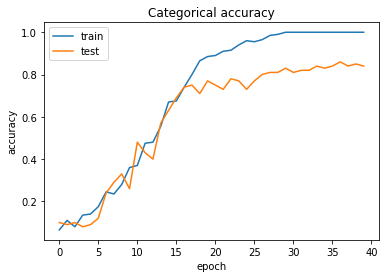

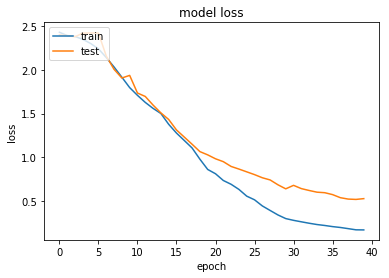

In [17]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
results.history

{'loss': [2.426994562149048,
  2.3888701796531677,
  2.3788636326789856,
  2.3456032276153564,
  2.298753023147583,
  2.2374395728111267,
  2.139377772808075,
  2.0309066772460938,
  1.9144574999809265,
  1.7959380447864532,
  1.7075940072536469,
  1.6271534264087677,
  1.5588998794555664,
  1.5007154047489166,
  1.3774490356445312,
  1.2773765623569489,
  1.1927100121974945,
  1.107442557811737,
  0.9797272235155106,
  0.862613782286644,
  0.8136516660451889,
  0.7368520945310593,
  0.6934387981891632,
  0.6351851522922516,
  0.5582371652126312,
  0.5165581926703453,
  0.4467615708708763,
  0.39501237124204636,
  0.34394560009241104,
  0.3024626448750496,
  0.2823794111609459,
  0.26566142216324806,
  0.24934187904000282,
  0.23463618755340576,
  0.22381757572293282,
  0.21099364757537842,
  0.20102212950587273,
  0.1878303922712803,
  0.1743181310594082,
  0.17324333265423775],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0004,
  0.0004,


In [0]:
#load best model according to cross-validation - model-attRNN
model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

In [0]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [21]:
valEval = model.evaluate_generator(valGen, use_multiprocessing=True, workers=4,verbose=1)
trainEval = model.evaluate_generator(trainGen, use_multiprocessing=True, workers=4,verbose=1)
testEval = model.evaluate(x_test, y_test, verbose=1)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

103/103 [==============================] - 1s 5ms/step
Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.20196233317255974, 1.0] 
Validation: [0.5249898284673691, 0.8699999749660492] 
Test: [0.4222216672689012, 0.9029126219379092]


In [22]:
#only for the Kaggle competition, 12-cmd
x_testR, y_testR = testRGen.__getitem__(0)
testREval = model.evaluate(x_testR, y_testR, verbose=1)
testREval

103/103 [==============================] - 0s 2ms/step


[0.4222217511783526, 0.9029126213592233]

In [23]:
testREval = model.evaluate_generator(testRGen, use_multiprocessing=True, workers=4,verbose=1)
testREval

1/1 [==============================] - 1s 950ms/step


[0.4222217798233032, 0.9029126167297363]

# Evaluation and Attention Plots




In [0]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('mel_stft').output])


In [25]:
audios, classes = valGen.__getitem__(3)
classes

array([ 7,  3,  2,  1,  8,  0,  3,  7, 10, 10, 10,  8,  7, 10,  8,  7,  3,
        5,  3,  5,  8,  4,  1,  6, 10,  5,  2,  8,  4,  5,  1,  0,  0,  6,
        5,  3,  2,  0,  1,  9,  2,  6,  0, 10,  1,  4,  3, 10,  9,  6])

In [26]:
#8 - on, 13 - one, 7 - right
idAudio = 6
classes[idAudio]

3

In [0]:
outs, attW, specs = attSpeechModel.predict( audios )

In [28]:
np.argmax(outs,axis=1)

array([10, 10, 10, 10, 10, 10, 10, 10,  3, 10, 10, 10,  3, 10, 10, 10, 10,
       10, 10, 10,  7, 10,  7,  7,  7,  7, 10, 10, 10, 10, 10, 10,  3,  3,
        7, 10, 10, 10, 10, 10, 10, 10, 10, 10,  3,  7, 10,  7, 10,  3])

In [29]:
specs.shape

(50, 80, 375, 1)

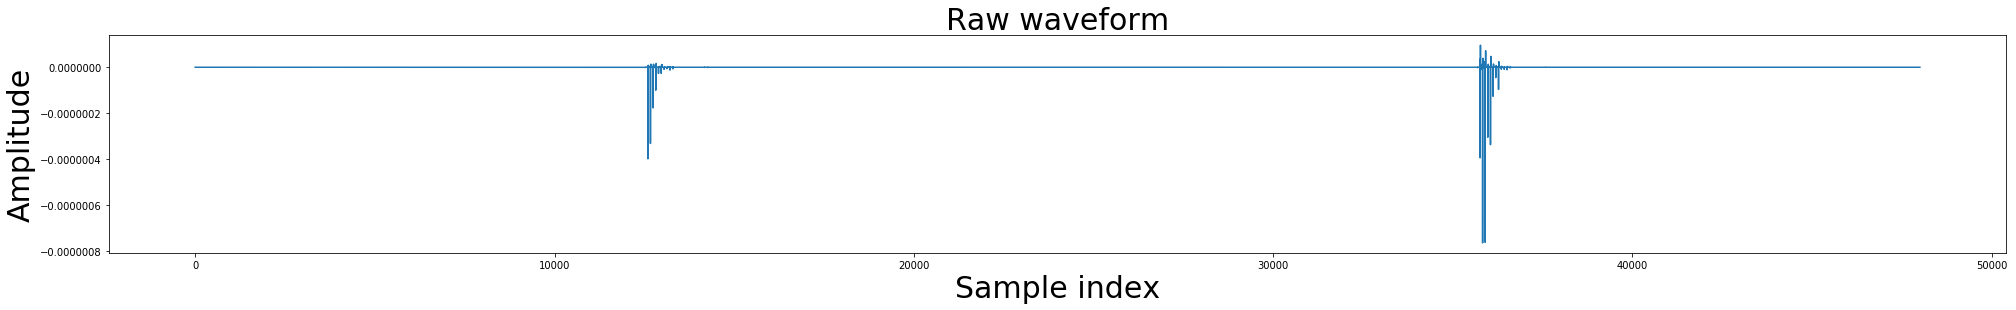

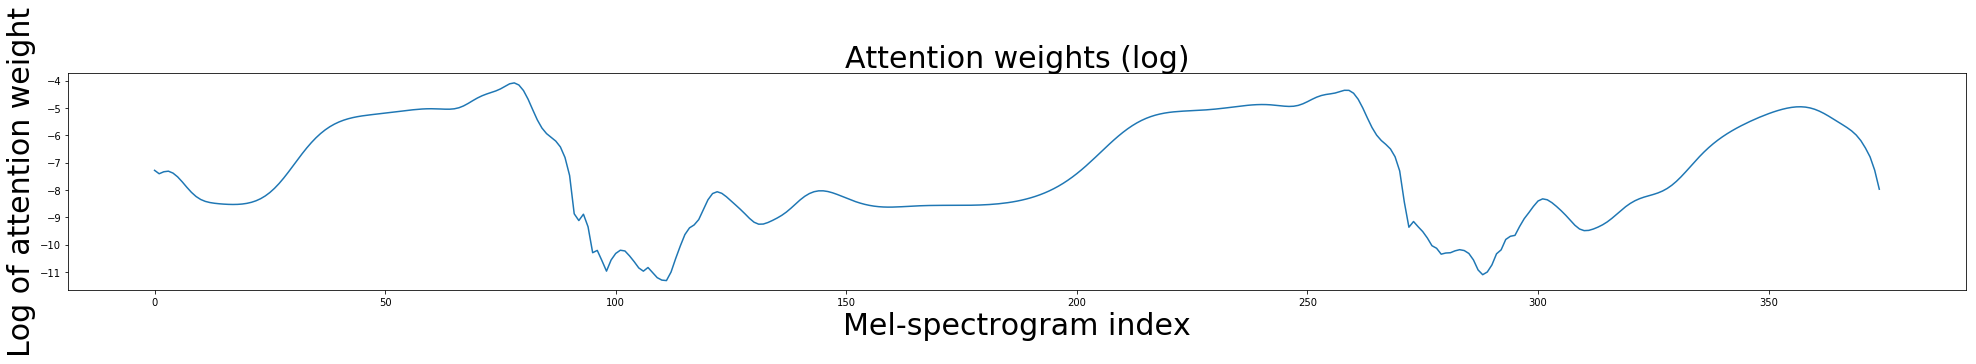

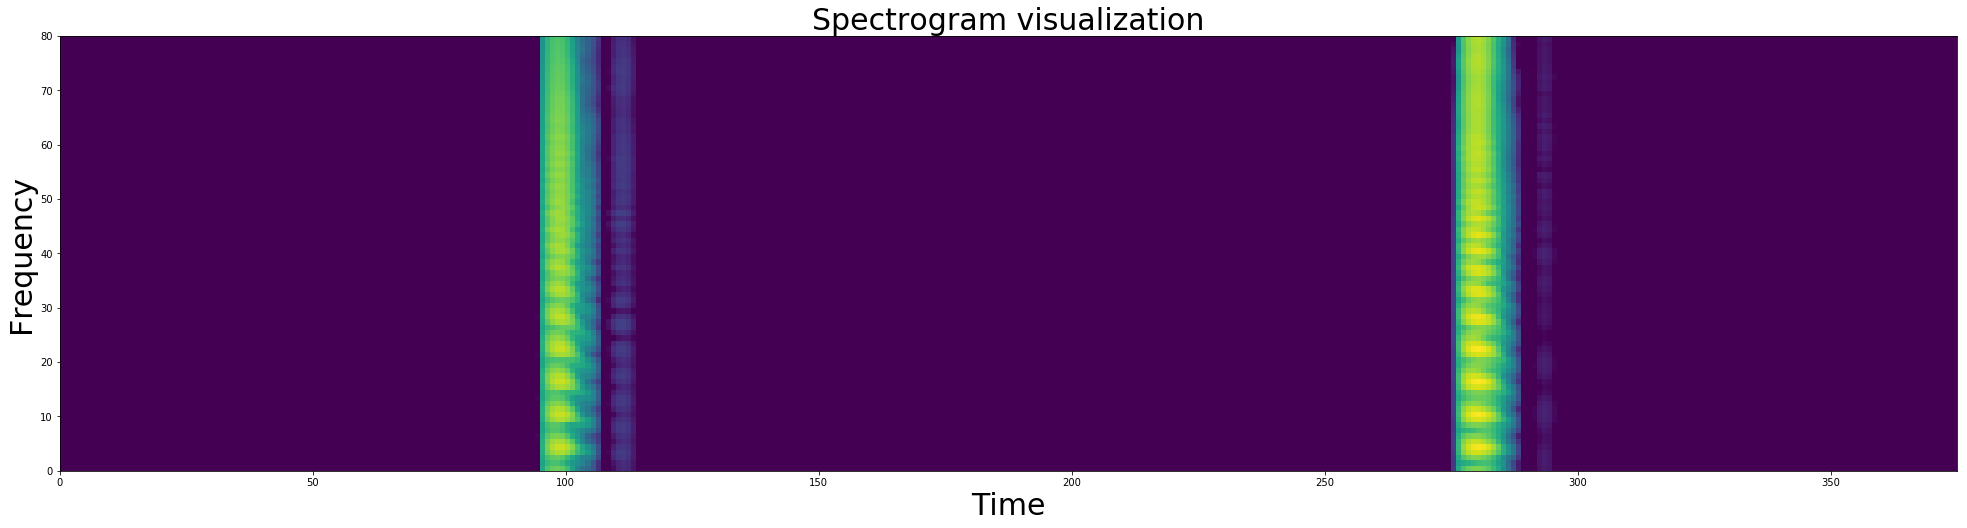

In [30]:

imgHeight = 2*2

plt.figure(figsize=(17*2,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17*2,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17*2,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [31]:
y_pred = model.predict(x_test, verbose=1)

103/103 [==============================] - 1s 7ms/step


In [0]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(np.argmax(y_pred,1),y_test)

In [33]:
set(y_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [0]:
#35word, v1
classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
         'marvin', 'sheila', 'tree', 'wow']

In [0]:
#10digit
classes=['background', 'cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete',  'ocho', 'nueve']

Confusion matrix, without normalization


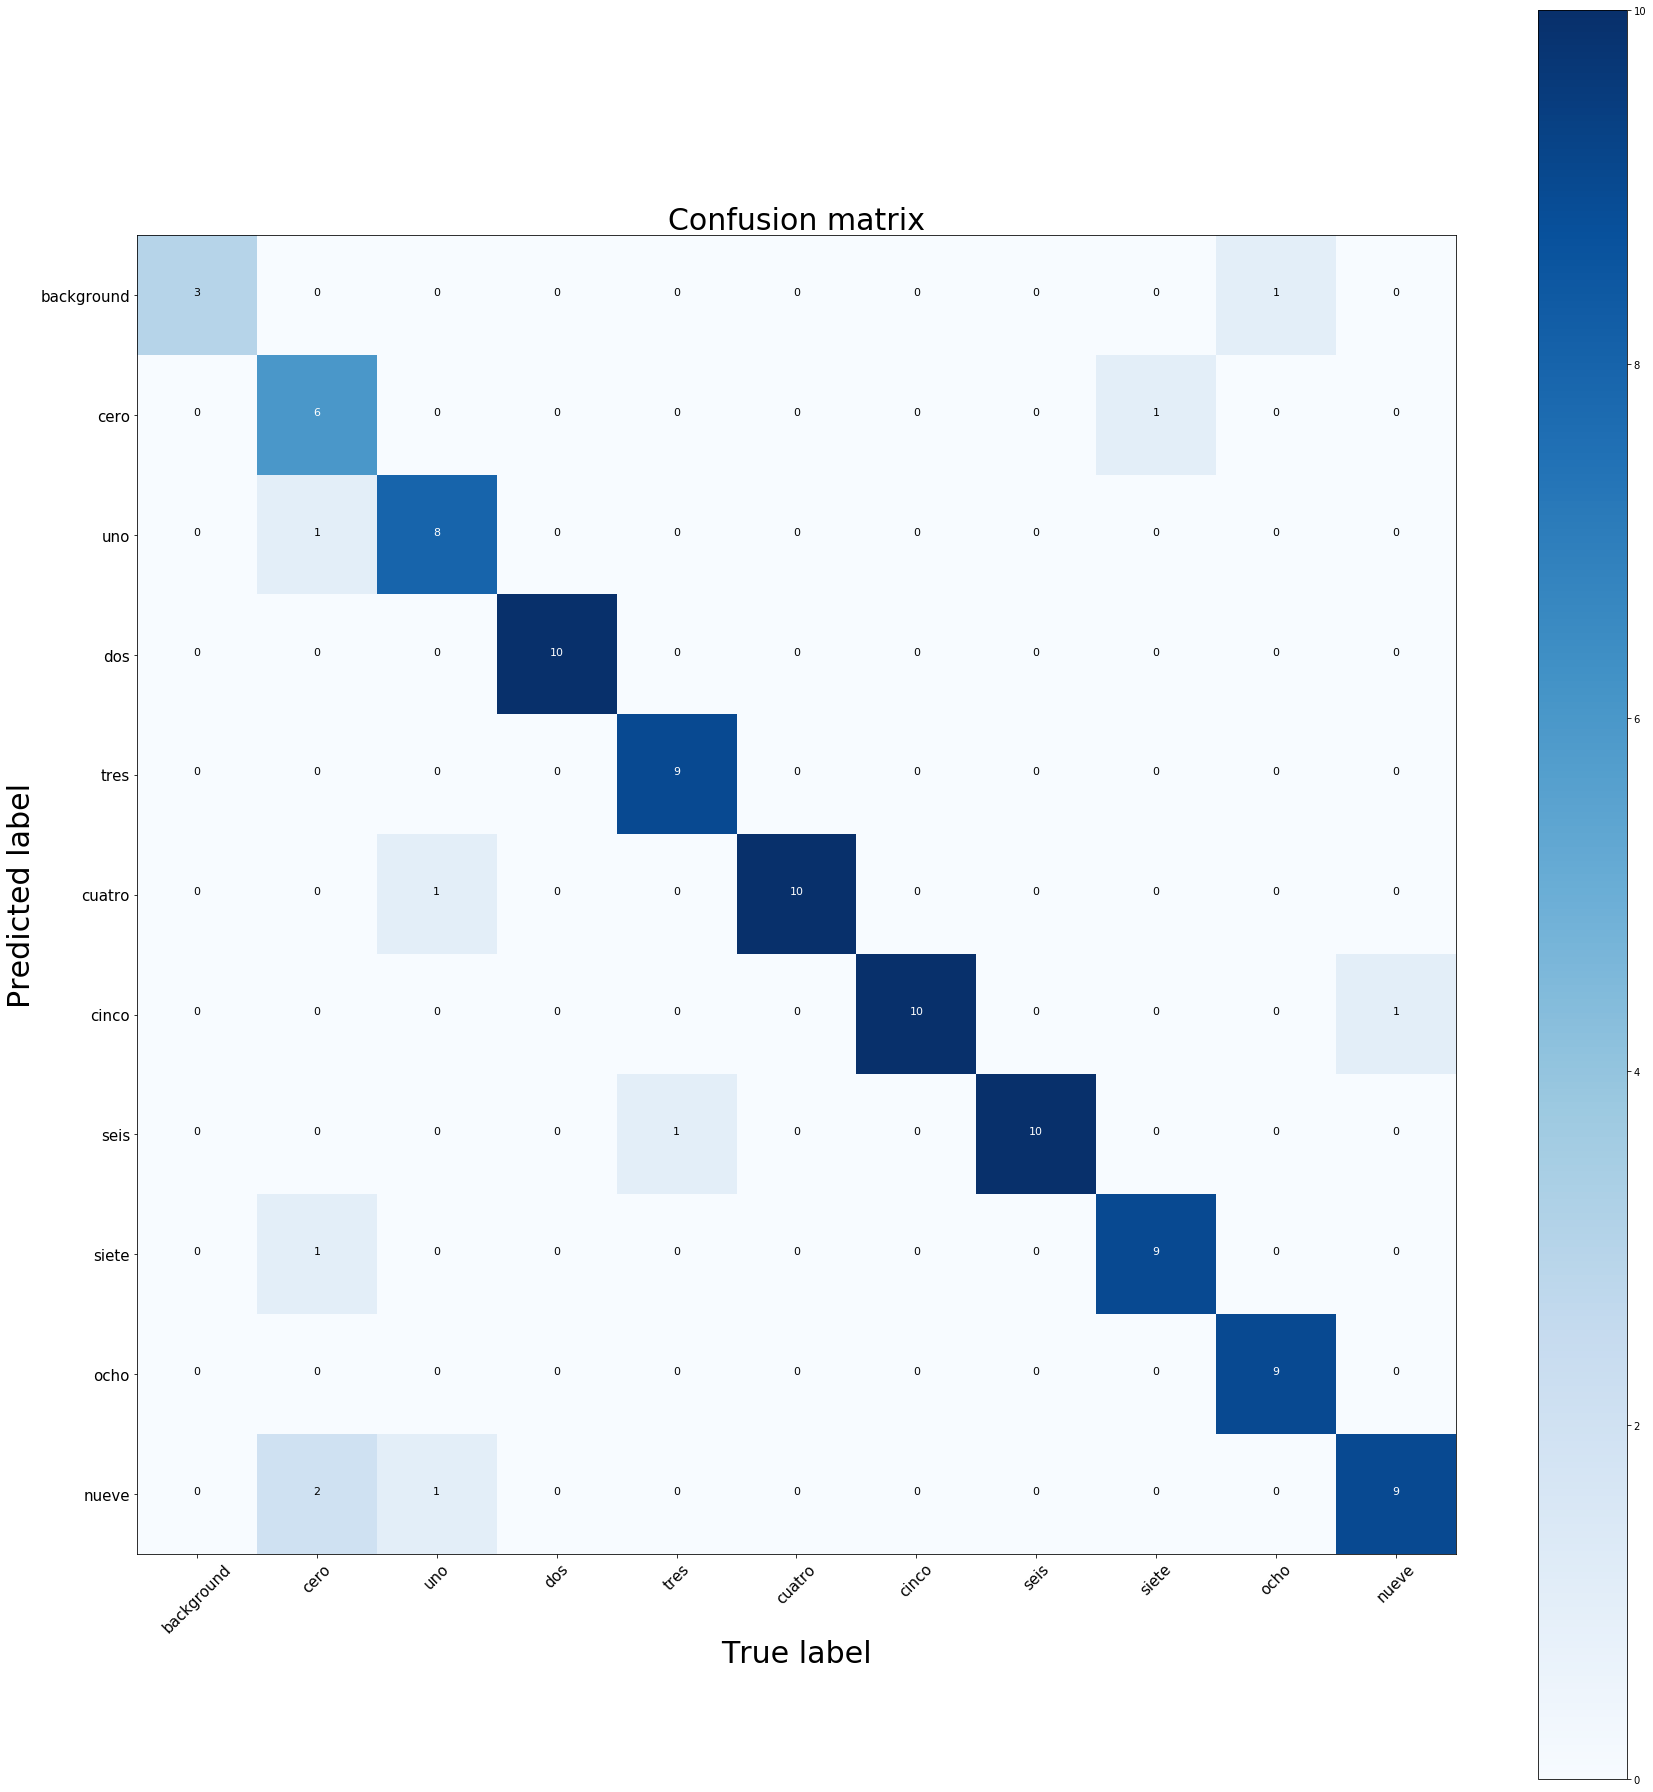

In [36]:
audioUtils.plot_confusion_matrix(cm,classes, normalize=False)